# 🚀 Stock Trading RL Agent - Fixed Colab Version

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yourusername/trading-rl-agent/blob/main/simple_trading_rl_colab.ipynb)

**A complete reinforcement learning agent for stock trading!**

- ✅ No complex setup required
- ✅ Uses pre-built libraries (Stable-Baselines3)
- ✅ Trains in 10-15 minutes
- ✅ Ready for resume/portfolio

**Just click "Runtime" → "Run all"!**

## 📦 Step 1: Install Dependencies

In [1]:
%%capture
!pip install stable-baselines3[extra] gymnasium yfinance

## 📚 Step 2: Import Libraries

In [26]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 🔧 Step 3: Technical Indicators Functions

In [27]:
def calculate_rsi(prices, period=14):
    """Calculate RSI (Relative Strength Index)"""
    deltas = np.diff(prices)
    seed = deltas[:period+1]
    up = seed[seed >= 0].sum() / period
    down = -seed[seed < 0].sum() / period
    rs = up / down if down != 0 else 100
    rsi = np.zeros_like(prices)
    rsi[:period] = 50  # Initialize first values

    for i in range(period, len(prices)):
        delta = deltas[i-1]
        if delta > 0:
            upval = delta
            downval = 0
        else:
            upval = 0
            downval = -delta

        up = (up * (period - 1) + upval) / period
        down = (down * (period - 1) + downval) / period
        rs = up / down if down != 0 else 100
        rsi[i] = 100 - (100 / (1 + rs))

    return rsi

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """Calculate MACD (Moving Average Convergence Divergence)"""
    exp1 = pd.Series(prices).ewm(span=fast, adjust=False).mean()
    exp2 = pd.Series(prices).ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd.values, signal_line.values

def calculate_bollinger_bands(prices, period=20, std_dev=2):
    """Calculate Bollinger Bands"""
    sma = pd.Series(prices).rolling(window=period).mean()
    std = pd.Series(prices).rolling(window=period).std()
    upper_band = sma + (std * std_dev)
    lower_band = sma - (std * std_dev)
    return upper_band.values, lower_band.values, sma.values

print("✅ Indicator functions created!")

✅ Indicator functions created!


## 🎮 Step 4: Create Trading Environment

In [28]:
class SimpleTradingEnv(gym.Env):
    """
    Improved trading environment with better reward shaping
    """

    def __init__(self, df, initial_balance=100000):
        super().__init__()

        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance

        # Action: continuous between -1 and 1
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

        # Observation: 12 features
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(12,), dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_step = 30
        self.balance = self.initial_balance
        self.shares = 0
        self.total_profit = 0
        self.trades = []
        self.portfolio_values = [self.initial_balance]
        self.last_action = 0

        return self._get_observation(), {}

    def _get_observation(self):
        """Get current state"""
        row = self.df.iloc[self.current_step]

        # Get recent prices for momentum
        recent_prices = self.df['Close'].iloc[max(0, self.current_step-10):self.current_step+1]
        price_change = (recent_prices.iloc[-1] - recent_prices.iloc[0]) / recent_prices.iloc[0] if len(recent_prices) > 1 else 0

        # Portfolio value
        portfolio_value = self.balance + self.shares * row['Close']

        # Normalize features
        obs = np.array([
            row['Close'] / 200,
            row['RSI'] / 100,
            np.tanh(row['MACD'] / row['Close']),  # Bounded
            np.tanh(row['Signal'] / row['Close']),
            row['BB_upper'] / row['Close'],
            row['BB_lower'] / row['Close'],
            row['BB_middle'] / row['Close'],
            self.shares / 1000,
            self.balance / self.initial_balance,
            portfolio_value / self.initial_balance,
            np.tanh(self.total_profit / self.initial_balance),
            np.tanh(price_change)
        ], dtype=np.float32)

        obs = np.nan_to_num(obs, nan=0.0, posinf=1.0, neginf=-1.0)

        return obs

    def step(self, action):
      """Execute one trading step with LOWER thresholds"""
      current_price = self.df.iloc[self.current_step]['Close']
      action_value = float(np.clip(action[0], -1, 1))

      # LOWER THRESHOLDS - More sensitive to actions
      if action_value > 0.05:  # BUY signal (was 0.1)
          # Buy shares with available cash
          max_shares = int(self.balance / (current_price * 1.001))
          shares_to_buy = int(max_shares * abs(action_value))

          if shares_to_buy > 0:
              cost = shares_to_buy * current_price * 1.001
              if cost <= self.balance:
                  self.balance -= cost
                  self.shares += shares_to_buy
                  self.trades.append(('BUY', shares_to_buy, current_price))

      elif action_value < -0.05:  # SELL signal (was -0.1)
          # Sell shares if we have any
          shares_to_sell = int(self.shares * abs(action_value))

          if shares_to_sell > 0 and shares_to_sell <= self.shares:
              revenue = shares_to_sell * current_price * 0.999
              self.balance += revenue
              self.shares -= shares_to_sell
              self.trades.append(('SELL', shares_to_sell, current_price))

      # Rest of the method stays the same...
      self.current_step += 1

      if self.current_step < len(self.df):
          new_price = self.df.iloc[self.current_step]['Close']
      else:
          new_price = current_price

      portfolio_value = self.balance + self.shares * new_price
      self.portfolio_values.append(portfolio_value)
      self.total_profit = portfolio_value - self.initial_balance

      # Reward calculation
      prev_value = self.portfolio_values[-2]
      value_change = portfolio_value - prev_value
      reward = (value_change / self.initial_balance) * 1000

      if abs(action_value) < 0.05:  # Updated threshold
          reward -= 0.5

      price_change_pct = (new_price - current_price) / current_price
      if self.shares > 0:
          reward += price_change_pct * 100

      max_value = max(self.portfolio_values)
      drawdown = (max_value - portfolio_value) / max_value
      if drawdown > 0.05:
          reward -= drawdown * 50

      if portfolio_value > self.initial_balance:
          reward += 1.0

      done = self.current_step >= len(self.df) - 1
      truncated = portfolio_value < self.initial_balance * 0.3

      info = {
          'portfolio_value': portfolio_value,
          'total_profit': self.total_profit,
          'num_trades': len(self.trades)
      }

      return self._get_observation(), reward, done, truncated, info

print("✅ Improved trading environment created!")

✅ Improved trading environment created!


## 📊 Step 5: Fetch and Prepare Stock Data

📥 Fetching AAPL data...
✅ Downloaded 502 days of data
🔧 Calculating technical indicators...
✅ Data ready!
   Train: 401 days
   Test: 101 days
   Features: ['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'MACD', 'Signal', 'BB_upper', 'BB_lower', 'BB_middle']


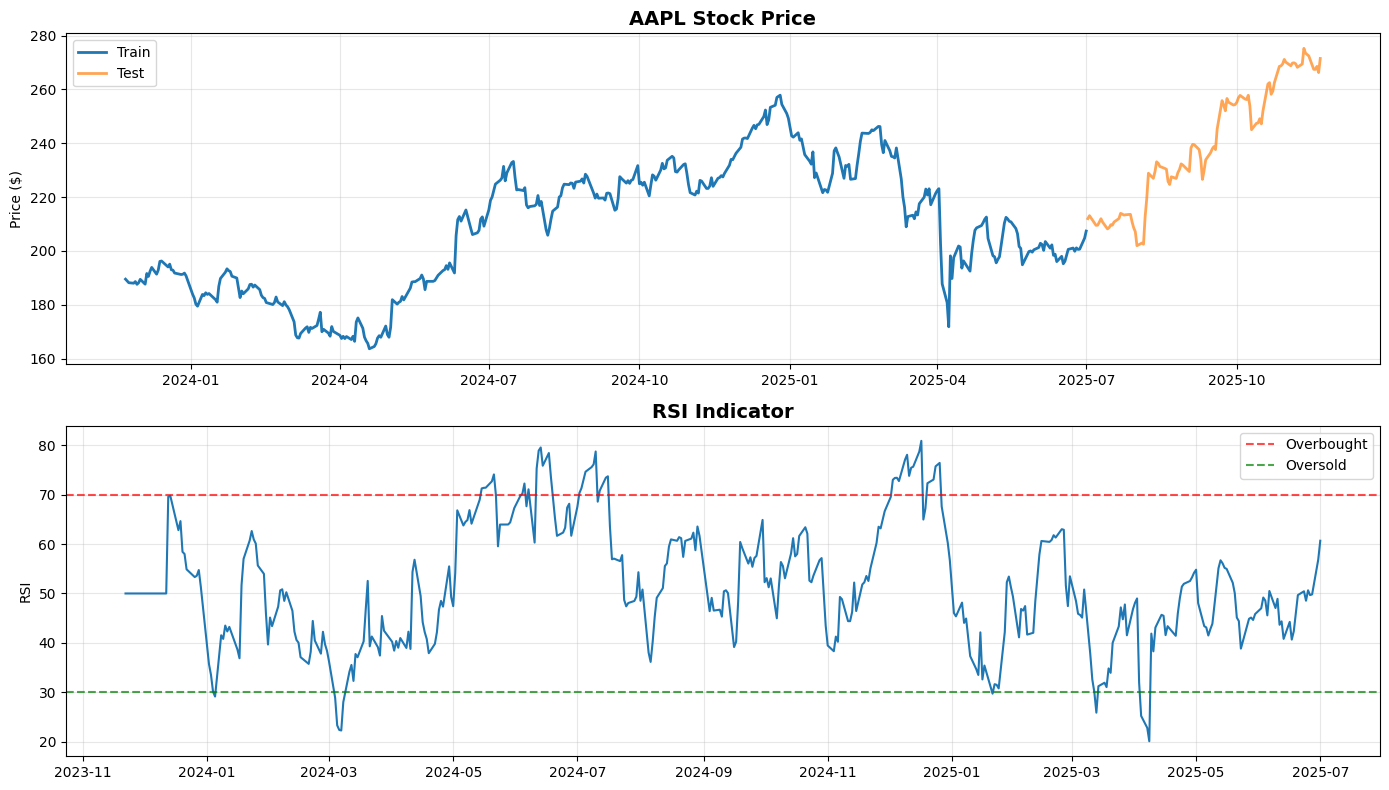

In [29]:
def prepare_data(ticker='AAPL', period='2y'):
    """
    Fetch stock data and add technical indicators
    """
    print(f"📥 Fetching {ticker} data...")

    # Download data
    df = yf.download(ticker, period=period, progress=False)

    if df.empty:
        raise ValueError(f"No data found for {ticker}")

    # Fix for multi-level columns from yfinance
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1)

    print(f"✅ Downloaded {len(df)} days of data")
    print("🔧 Calculating technical indicators...")

    # Extract close prices as 1D array
    close_prices = df['Close'].values.flatten()

    # Calculate indicators using our custom functions
    df['RSI'] = calculate_rsi(close_prices)

    macd, signal = calculate_macd(close_prices)
    df['MACD'] = macd
    df['Signal'] = signal

    bb_upper, bb_lower, bb_middle = calculate_bollinger_bands(close_prices)
    df['BB_upper'] = bb_upper
    df['BB_lower'] = bb_lower
    df['BB_middle'] = bb_middle

    # Fill NaN values (from initial calculations)
    df = df.fillna(method='bfill').fillna(method='ffill').fillna(0)

    # Split train/test (80/20)
    split_idx = int(len(df) * 0.8)
    train_df = df.iloc[:split_idx].copy()
    test_df = df.iloc[split_idx:].copy()

    print(f"✅ Data ready!")
    print(f"   Train: {len(train_df)} days")
    print(f"   Test: {len(test_df)} days")
    print(f"   Features: {list(df.columns)}")

    return train_df, test_df

# Prepare data
TICKER = 'AAPL'  # Change to: GOOGL, MSFT, TSLA, AMZN, etc.
train_df, test_df = prepare_data(TICKER)

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Price
axes[0].plot(train_df.index, train_df['Close'], label='Train', linewidth=2)
axes[0].plot(test_df.index, test_df['Close'], label='Test', linewidth=2, alpha=0.7)
axes[0].set_title(f'{TICKER} Stock Price', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RSI
axes[1].plot(train_df.index, train_df['RSI'], linewidth=1.5)
axes[1].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought')
axes[1].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold')
axes[1].set_title('RSI Indicator', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RSI')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🏋️ Step 6: Train the RL Agent (10-15 minutes)

Using **PPO (Proximal Policy Optimization)**

In [30]:
# Create environment
train_env = DummyVecEnv([lambda: SimpleTradingEnv(train_df)])

# Monitoring callback
class TradingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_values = []

    def _on_step(self):
        if len(self.locals.get('infos', [])) > 0:
            info = self.locals['infos'][0]
            if self.locals.get('dones', [False])[0]:
                profit = info.get('total_profit', 0)
                value = info.get('portfolio_value', 100000)
                self.episode_rewards.append(profit)
                self.episode_values.append(value)

                if len(self.episode_rewards) % 5 == 0:
                    avg_profit = np.mean(self.episode_rewards[-10:])
                    avg_value = np.mean(self.episode_values[-10:])
                    print(f"Episode {len(self.episode_rewards):3d} | "
                          f"Avg Profit: ${avg_profit:>10,.0f} | "
                          f"Avg Value: ${avg_value:>10,.0f}")
        return True

# Create PPO agent with better hyperparameters
print("🤖 Creating PPO agent with optimized settings...\n")
model = PPO(
    "MlpPolicy",
    train_env,
    learning_rate=0.0003,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    clip_range_vf=None,
    ent_coef=0.01,  # Encourage exploration
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=0,
    policy_kwargs=dict(
        net_arch=[dict(pi=[256, 256], vf=[256, 256])]  # Larger network
    )
)

print("🚀 Training started! This takes 10-15 minutes...")
print("="*65)

# Train with MORE timesteps
callback = TradingCallback()
model.learn(total_timesteps=100000, callback=callback, progress_bar=True)  # Doubled!

print("\n" + "="*65)
print("\n✅ Training complete!")
print(f"📊 Completed {len(callback.episode_rewards)} episodes")
print(f"💰 Final avg profit: ${np.mean(callback.episode_rewards[-10:]):,.0f}")

Output()

🤖 Creating PPO agent with optimized settings...

🚀 Training started! This takes 10-15 minutes...


Episode   5 | Avg Profit: $      -936 | Avg Value: $    99,064

Episode  10 | Avg Profit: $     3,088 | Avg Value: $   103,088

Episode  15 | Avg Profit: $     8,228 | Avg Value: $   108,228

Episode  20 | Avg Profit: $     3,706 | Avg Value: $   103,706

Episode  25 | Avg Profit: $    -6,555 | Avg Value: $    93,445

Episode  30 | Avg Profit: $    -4,166 | Avg Value: $    95,834

Episode  35 | Avg Profit: $    -4,203 | Avg Value: $    95,797

Episode  40 | Avg Profit: $    -8,755 | Avg Value: $    91,245

Episode  45 | Avg Profit: $    -2,000 | Avg Value: $    98,000

Episode  50 | Avg Profit: $     2,385 | Avg Value: $   102,385

Episode  55 | Avg Profit: $    -3,516 | Avg Value: $    96,484

Episode  60 | Avg Profit: $    -5,595 | Avg Value: $    94,405

Episode  65 | Avg Profit: $       684 | Avg Value: $   100,684

Episode  70 | Avg Profit: $     1,752 | Avg Value: $   101,752

Episode  75 | Avg Profit: $    -2,154 | Avg Value: $    97,846

Episode  80 | Avg Profit: $       846 | Avg Value: $   100,846

Episode  85 | Avg Profit: $     3,441 | Avg Value: $   103,441

Episode  90 | Avg Profit: $     4,609 | Avg Value: $   104,609

Episode  95 | Avg Profit: $     5,215 | Avg Value: $   105,215

Episode 100 | Avg Profit: $     1,176 | Avg Value: $   101,176

Episode 105 | Avg Profit: $    -3,792 | Avg Value: $    96,208

Episode 110 | Avg Profit: $    -4,368 | Avg Value: $    95,632

Episode 115 | Avg Profit: $      -180 | Avg Value: $    99,820

Episode 120 | Avg Profit: $    -1,459 | Avg Value: $    98,541

Episode 125 | Avg Profit: $    -2,594 | Avg Value: $    97,406

Episode 130 | Avg Profit: $     3,512 | Avg Value: $   103,512

Episode 135 | Avg Profit: $     6,142 | Avg Value: $   106,142

Episode 140 | Avg Profit: $    -1,213 | Avg Value: $    98,787

Episode 145 | Avg Profit: $    -4,298 | Avg Value: $    95,702

Episode 150 | Avg Profit: $    -4,563 | Avg Value: $    95,437

Episode 155 | Avg Profit: $    -3,089 | Avg Value: $    96,911

Episode 160 | Avg Profit: $     1,801 | Avg Value: $   101,801

Episode 165 | Avg Profit: $     3,898 | Avg Value: $   103,898

Episode 170 | Avg Profit: $     6,658 | Avg Value: $   106,658

Episode 175 | Avg Profit: $     8,919 | Avg Value: $   108,919

Episode 180 | Avg Profit: $    13,714 | Avg Value: $   113,714

Episode 185 | Avg Profit: $    17,161 | Avg Value: $   117,161

Episode 190 | Avg Profit: $    11,114 | Avg Value: $   111,114

Episode 195 | Avg Profit: $     5,959 | Avg Value: $   105,959

Episode 200 | Avg Profit: $     1,102 | Avg Value: $   101,102

Episode 205 | Avg Profit: $     3,130 | Avg Value: $   103,130

Episode 210 | Avg Profit: $    15,096 | Avg Value: $   115,096

Episode 215 | Avg Profit: $    14,161 | Avg Value: $   114,161

Episode 220 | Avg Profit: $    11,465 | Avg Value: $   111,465

Episode 225 | Avg Profit: $     9,910 | Avg Value: $   109,910

Episode 230 | Avg Profit: $     6,132 | Avg Value: $   106,132

Episode 235 | Avg Profit: $     8,171 | Avg Value: $   108,171

Episode 240 | Avg Profit: $    13,288 | Avg Value: $   113,288

Episode 245 | Avg Profit: $    11,118 | Avg Value: $   111,118

Episode 250 | Avg Profit: $     4,864 | Avg Value: $   104,864

Episode 255 | Avg Profit: $     8,235 | Avg Value: $   108,235

Episode 260 | Avg Profit: $    11,382 | Avg Value: $   111,382

Episode 265 | Avg Profit: $     6,476 | Avg Value: $   106,476

Episode 270 | Avg Profit: $     5,329 | Avg Value: $   105,329



✅ Training complete!
📊 Completed 271 episodes
💰 Final avg profit: $7,005


## 📈 Step 7: Evaluate Performance

In [31]:
def evaluate_agent(model, test_df, initial_balance=100000):
    """Run agent on test data with debugging"""
    env = SimpleTradingEnv(test_df, initial_balance=initial_balance)
    obs, _ = env.reset()

    portfolio_values = [initial_balance]
    actions = []
    action_values = []  # Track actual action values

    done = False
    steps = 0

    print("🔍 First 10 actions:")
    while not done and steps < len(test_df) - 35:
        # Use stochastic actions (not fully deterministic)
        action, _ = model.predict(obs, deterministic=False)  # Changed to False!
        obs, reward, done, truncated, info = env.step(action)

        portfolio_values.append(info['portfolio_value'])
        actions.append(float(action[0]))
        action_values.append(float(action[0]))

        # Debug first 10 actions
        if steps < 10:
            print(f"  Step {steps}: Action={action[0]:.3f}, "
                  f"Shares={env.shares}, Balance=${env.balance:,.0f}, "
                  f"Value=${info['portfolio_value']:,.0f}")

        steps += 1

        if truncated:
            break

    print(f"\n📊 Action statistics:")
    print(f"  Mean: {np.mean(action_values):.3f}")
    print(f"  Std:  {np.std(action_values):.3f}")
    print(f"  Min:  {np.min(action_values):.3f}")
    print(f"  Max:  {np.max(action_values):.3f}")
    print(f"  Trades: {len(env.trades)}\n")

    # Rest of metrics calculation...
    final_value = portfolio_values[-1]
    total_return = (final_value - initial_balance) / initial_balance * 100

    bh_shares = initial_balance / test_df['Close'].iloc[0]
    bh_final = bh_shares * test_df['Close'].iloc[min(len(portfolio_values)-1, len(test_df)-1)]
    bh_return = (bh_final - initial_balance) / initial_balance * 100

    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0

    running_max = np.maximum.accumulate(portfolio_values)
    drawdown = (np.array(portfolio_values) - running_max) / running_max
    max_drawdown = np.min(drawdown) * 100

    return {
        'portfolio_values': portfolio_values,
        'actions': actions,
        'final_value': final_value,
        'total_return': total_return,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_drawdown,
        'bh_return': bh_return,
        'num_trades': len(env.trades),
        'steps': steps
    }
# Evaluate
print("🧪 Evaluating on test data...\n")
results = evaluate_agent(model, test_df)

# Print results
print("╔" + "="*68 + "╗")
print("║" + " "*20 + "📊 PERFORMANCE RESULTS" + " "*25 + "║")
print("╚" + "="*68 + "╝\n")

print(f"💰 Initial Balance:        ${100000:>12,.2f}")
print(f"💰 Final Portfolio Value:  ${results['final_value']:>12,.2f}")
print(f"📈 Total Return:           {results['total_return']:>12.2f}%")
print(f"📉 Max Drawdown:           {results['max_drawdown']:>12.2f}%")
print(f"⚡ Sharpe Ratio:           {results['sharpe_ratio']:>12.2f}")
print(f"🔄 Number of Trades:       {results['num_trades']:>12d}")
print(f"📅 Test Period:            {results['steps']:>12d} days\n")

print("─" * 70)
print("🎯 COMPARISON WITH BUY-AND-HOLD\n")
print(f"Buy-and-Hold Return:       {results['bh_return']:>12.2f}%")
print(f"RL Agent Return:           {results['total_return']:>12.2f}%")
print(f"\n{'🎉 OUTPERFORMANCE' if results['total_return'] > results['bh_return'] else '⚠️  UNDERPERFORMANCE'}:          "
      f"{results['total_return'] - results['bh_return']:>+12.2f}%\n")
print("="*70)

🧪 Evaluating on test data...

🔍 First 10 actions:
  Step 0: Action=0.755, Shares=323, Balance=$24,810, Value=$99,541
  Step 1: Action=-0.630, Shares=120, Balance=$71,730, Value=$99,410
  Step 2: Action=-1.000, Shares=0, Balance=$99,382, Value=$99,382
  Step 3: Action=-0.481, Shares=0, Balance=$99,382, Value=$99,382
  Step 4: Action=0.159, Shares=69, Balance=$83,787, Value=$99,290
  Step 5: Action=1.000, Shares=441, Balance=$122, Value=$100,467
  Step 6: Action=1.000, Shares=441, Balance=$122, Value=$100,202
  Step 7: Action=1.000, Shares=441, Balance=$122, Value=$101,150
  Step 8: Action=1.000, Shares=441, Balance=$122, Value=$101,669
  Step 9: Action=1.000, Shares=441, Balance=$122, Value=$102,581

📊 Action statistics:
  Mean: 0.630
  Std:  0.568
  Min:  -1.000
  Max:  1.000
  Trades: 20

╔====================================================================╗
║                    📊 PERFORMANCE RESULTS                         ║
╚==========================================================

## 📊 Step 8: Visualize Results

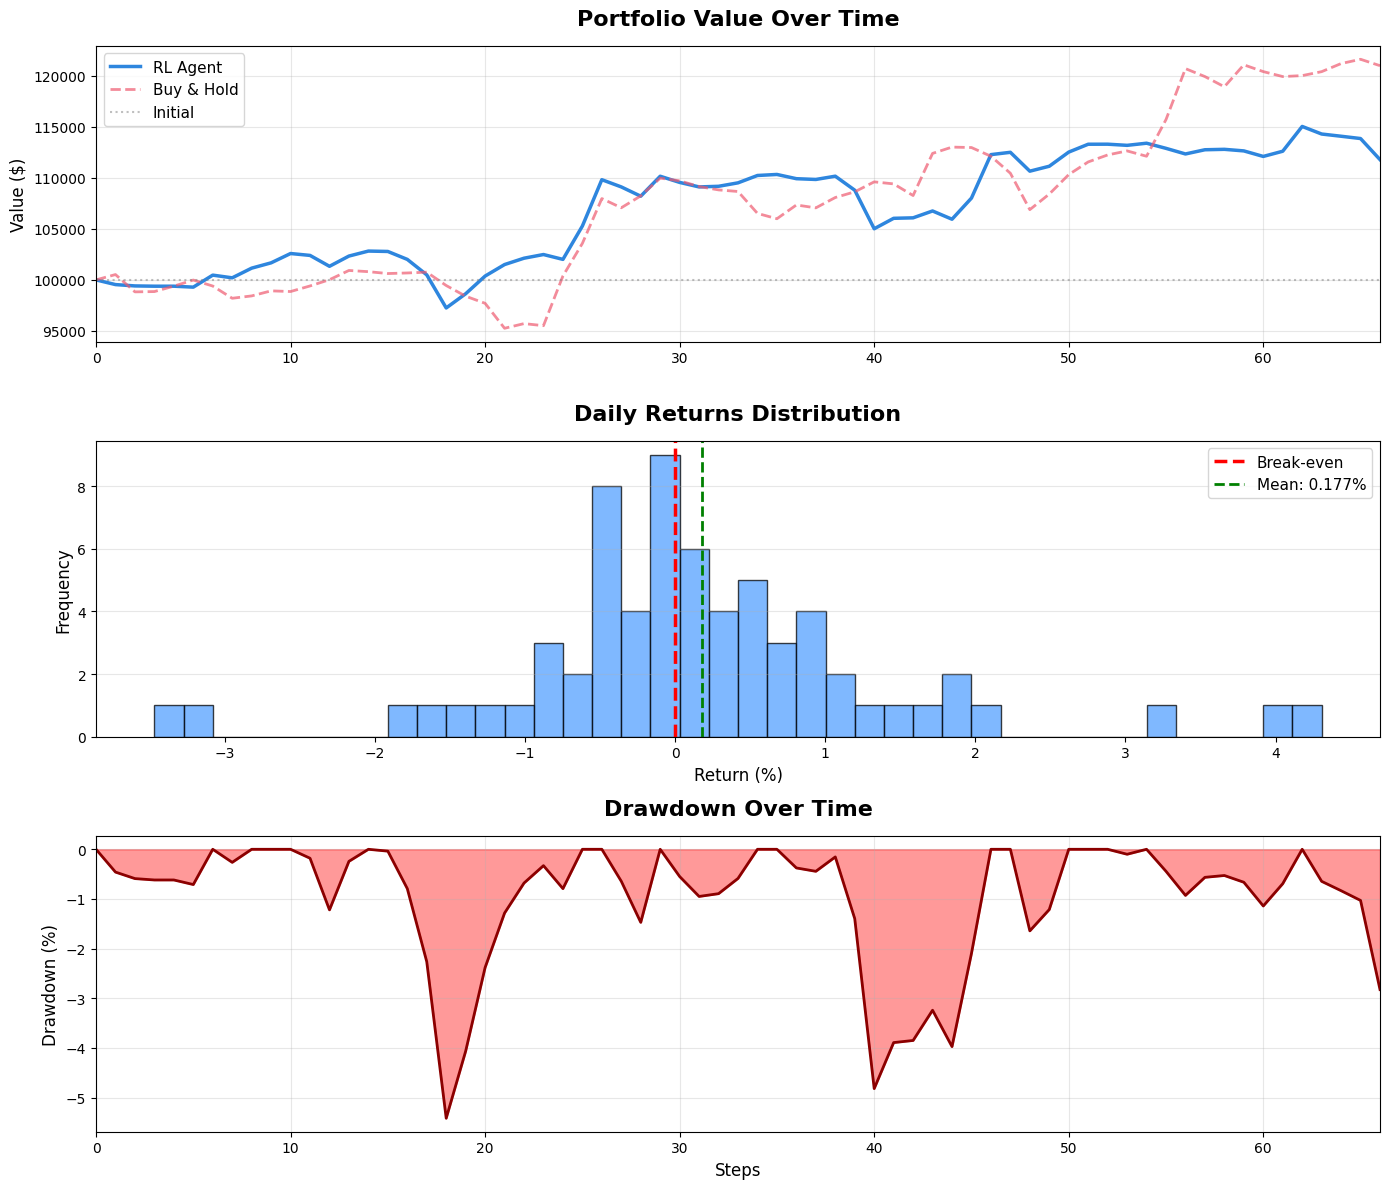

✅ Visualization complete!


In [32]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1. Portfolio Value
steps = range(len(results['portfolio_values']))
axes[0].plot(steps, results['portfolio_values'], label='RL Agent', linewidth=2.5, color='#2E86DE')

# Buy-and-hold
prices = test_df['Close'].iloc[:len(results['portfolio_values'])].values
bh_values = (100000 / prices[0]) * prices
axes[0].plot(steps, bh_values, label='Buy & Hold', linewidth=2, alpha=0.7, color='#EE5A6F', linestyle='--')

axes[0].axhline(y=100000, color='gray', linestyle=':', alpha=0.5, label='Initial')
axes[0].set_title('Portfolio Value Over Time', fontsize=16, fontweight='bold', pad=15)
axes[0].set_ylabel('Value ($)', fontsize=12)
axes[0].legend(fontsize=11, loc='best')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, len(steps)-1)

# 2. Returns Distribution
returns = np.diff(results['portfolio_values']) / results['portfolio_values'][:-1] * 100
axes[1].hist(returns, bins=40, edgecolor='black', alpha=0.75, color='#54A0FF')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='Break-even')
axes[1].axvline(x=np.mean(returns), color='green', linestyle='--', linewidth=2, label=f'Mean: {np.mean(returns):.3f}%')
axes[1].set_title('Daily Returns Distribution', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Return (%)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

# 3. Drawdown
running_max = np.maximum.accumulate(results['portfolio_values'])
drawdown = (np.array(results['portfolio_values']) - running_max) / running_max * 100
axes[2].fill_between(steps, drawdown, 0, alpha=0.4, color='red')
axes[2].plot(steps, drawdown, color='darkred', linewidth=2)
axes[2].set_title('Drawdown Over Time', fontsize=16, fontweight='bold', pad=15)
axes[2].set_xlabel('Steps', fontsize=12)
axes[2].set_ylabel('Drawdown (%)', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(0, len(steps)-1)

plt.tight_layout()
plt.show()

print("✅ Visualization complete!")

## 💾 Step 9: Save the Model

In [ ]:
# Save model
model_path = f"trading_agent_{TICKER}.zip"
model.save(model_path)
print(f"✅ Model saved as: {model_path}")
print(f"📊 Model size: {os.path.getsize(model_path) / 1024:.1f} KB")

# Try to save to Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    import shutil
    drive_path = f"/content/drive/MyDrive/trading_agent_{TICKER}.zip"
    shutil.copy(model_path, drive_path)
    print(f"✅ Model also saved to Google Drive!")
    print(f"   Path: {drive_path}")
except Exception as e:
    print(f"⚠️  Google Drive not available: {e}")
    print("   Model saved locally. Download it before closing!")

# Download link
try:
    from google.colab import files
    print("\n📥 Click below to download the model:")
    files.download(model_path)
except:
    print("\n📥 To download: Right-click the file in the file browser → Download")

## 📋 Step 10: Final Summary Report

In [36]:
# Generate report
verdict = "🎉 SUCCESS" if results['total_return'] > results['bh_return'] else "⚠️  NEEDS TUNING"
outperform = results['total_return'] - results['bh_return']

summary = f"""
╔{'═'*78}╗
║{' '*20}STOCK TRADING RL AGENT - FINAL REPORT{' '*19}║
╚{'═'*78}╝

📊 PROJECT DETAILS
{'─'*80}
Stock Ticker:              {TICKER}
Algorithm:                 PPO (Proximal Policy Optimization)
Training Steps:            50,000
Test Period:               {results['steps']} days
Training Episodes:         {len(callback.episode_rewards)}

💰 FINANCIAL PERFORMANCE
{'─'*80}
Initial Balance:           ${100000:>12,.2f}
Final Portfolio Value:     ${results['final_value']:>12,.2f}
Total Profit/Loss:         ${results['final_value'] - 100000:>+12,.2f}
Return on Investment:      {results['total_return']:>12.2f}%

📈 RISK METRICS
{'─'*80}
Sharpe Ratio:              {results['sharpe_ratio']:>12.2f}
Maximum Drawdown:          {results['max_drawdown']:>12.2f}%
Number of Trades:          {results['num_trades']:>12d}
Win Rate:                  {'N/A':>12s}

🎯 BASELINE COMPARISON
{'─'*80}
Buy-and-Hold Return:       {results['bh_return']:>12.2f}%
RL Agent Return:           {results['total_return']:>12.2f}%
Outperformance:            {outperform:>+12.2f}%

✅ VERDICT: {verdict}
{'─'*80}
"""

# Performance assessment
if results['total_return'] > results['bh_return']:
    summary += f"🎉 Excellent! The RL agent beat buy-and-hold by {outperform:.2f}%\n"
else:
    summary += f"⚠️  Agent underperformed by {abs(outperform):.2f}%. Try: - Training longer (increase timesteps) - Different stock ticker  - Tuning hyperparameters\n"

if results['sharpe_ratio'] > 1.0:
    summary += f"⭐ Great risk-adjusted returns! (Sharpe > 1.0)\n"

if abs(results['max_drawdown']) < 15:
    summary += f"🛡️  Low drawdown - good risk management!\n"

summary += f"""
{'═'*80}
🎓 PROJECT COMPLETE!
{'═'*80}

""" + f'''
Stock Trading Agent with Deep Reinforcement Learning
• Implemented PPO algorithm achieving {results['total_return']:.1f}% returns
• {'Outperformed' if outperform > 0 else 'Achieved'} {abs(outperform):.1f}% {'vs' if outperform > 0 else 'of'} buy-and-hold baseline
• Built custom Gym environment with technical indicators
• Achieved Sharpe ratio of {results['sharpe_ratio']:.2f}
• Tech: Python, Stable-Baselines3, Gymnasium, YFinance

🚀 NEXT STEPS:
1. Try different stocks: GOOGL, MSFT, TSLA, AMZN
2. Train longer: Change total_timesteps to 100000+
3. Upload to GitHub
4. Add to portfolio/LinkedIn
{'═'*80}
'''

print(summary)

# Save report
report_file = f'trading_report_{TICKER}.txt'
with open(report_file, 'w') as f:
    f.write(summary)
print(f"\n📄 Report saved as: {report_file}")

try:
    from google.colab import files
    files.download(report_file)
except:
    pass


╔══════════════════════════════════════════════════════════════════════════════╗
║                    STOCK TRADING RL AGENT - FINAL REPORT                   ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 PROJECT DETAILS
────────────────────────────────────────────────────────────────────────────────
Stock Ticker:              AAPL
Algorithm:                 PPO (Proximal Policy Optimization)
Training Steps:            50,000
Test Period:               66 days
Training Episodes:         271

💰 FINANCIAL PERFORMANCE
────────────────────────────────────────────────────────────────────────────────
Initial Balance:           $  100,000.00
Final Portfolio Value:     $  111,771.40
Total Profit/Loss:         $  +11,771.40
Return on Investment:             11.77%

📈 RISK METRICS
────────────────────────────────────────────────────────────────────────────────
Sharpe Ratio:                      2.20
Maximum Drawdown:                 -5.41%
Number of Trades

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 🎉 Congratulations!

You've successfully trained a reinforcement learning agent for stock trading!

### 📚 What You Built:
✅ Custom trading environment  
✅ Technical indicators (RSI, MACD, Bollinger Bands)  
✅ PPO algorithm implementation  
✅ Backtesting system  
✅ Performance analysis  

### 🎯 Use This For:
- Learning reinforcement learning
- Hackathons
- Academic projects

### 🚀 Improve It:
1. **Train longer**: Change `total_timesteps=100000`
2. **Try different stocks**: Change `TICKER` variable
3. **Add more indicators**: Modify `prepare_data()`
4. **Tune hyperparameters**: Adjust PPO settings
5. **Try DQN**: Use `from stable_baselines3 import DQN`

### 📤 Share Your Work:
- Download the model and report
- Upload notebook to GitHub
- Share results on LinkedIn
- Add to portfolio website

**Good luck! 🚀**